# Financial Analysis with TimeSeries data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#from statsmodels.stats.stattools import durbin_watso
from sktime.utils.plotting import plot_series

In [17]:
st=px.data.stocks()
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    105 non-null    object 
 1   GOOG    105 non-null    float64
 2   AAPL    105 non-null    float64
 3   AMZN    105 non-null    float64
 4   FB      105 non-null    float64
 5   NFLX    105 non-null    float64
 6   MSFT    105 non-null    float64
dtypes: float64(6), object(1)
memory usage: 5.9+ KB


In [18]:
st.head()

,date,GOOG,AAPL,AMZN,FB,NFLX,MSFT
0,2018-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2018-01-08,1.018172,1.011943,1.061881,0.959968,1.053526,1.015988
2,2018-01-15,1.032008,1.019771,1.053240,0.970243,1.049860,1.020524
3,2018-01-22,1.066783,0.980057,1.140676,1.016858,1.307681,1.066561
4,2018-01-29,1.008773,0.917143,1.163374,1.018357,1.273537,1.040708


In [19]:
st.index = pd.to_datetime(st['date'])
st = st.drop(columns='date')
st.head()

,GOOG,AAPL,AMZN,FB,NFLX,MSFT
date,,,,,,
2018-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-08,1.018172,1.011943,1.061881,0.959968,1.053526,1.015988
2018-01-15,1.032008,1.019771,1.053240,0.970243,1.049860,1.020524
2018-01-22,1.066783,0.980057,1.140676,1.016858,1.307681,1.066561
2018-01-29,1.008773,0.917143,1.163374,1.018357,1.273537,1.040708


In [20]:
st = st.sort_values(by='date')
st.index = st.index.to_period('D')
st.index

PeriodIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
             '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
             '2018-02-26', '2018-03-05',
             ...
             '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18',
             '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16',
             '2019-12-23', '2019-12-30'],
            dtype='period[D]', name='date', length=105)

In [21]:
st.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 105 entries, 2018-01-01 to 2019-12-30
Freq: D
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOG    105 non-null    float64
 1   AAPL    105 non-null    float64
 2   AMZN    105 non-null    float64
 3   FB      105 non-null    float64
 4   NFLX    105 non-null    float64
 5   MSFT    105 non-null    float64
dtypes: float64(6)
memory usage: 5.7 KB


In [22]:
st = st.resample('M', convention='end').mean()

In [23]:
st.head()

,GOOG,AAPL,AMZN,FB,NFLX,MSFT
date,,,,,,
2018-01,1.025147,0.985783,1.083834,0.993085,1.136921,1.028756
2018-02,0.983980,0.972214,1.177356,0.954482,1.327408,1.041189
2018-03,0.986439,0.986743,1.239377,0.922531,1.483618,1.047709
2018-04,0.941279,0.977120,1.223145,0.897190,1.485899,1.064270
2018-05,0.988854,1.076743,1.307615,1.001579,1.621339,1.114667


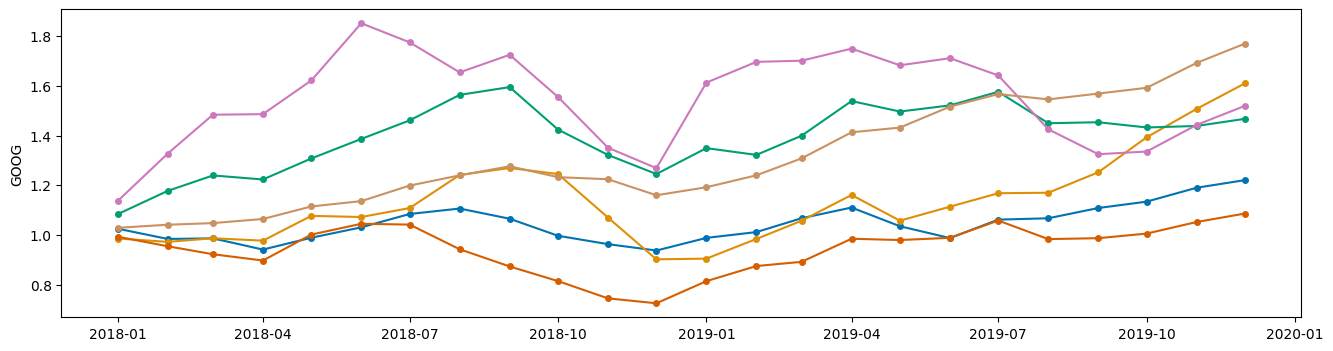

In [24]:
plot_series(st['GOOG'],st['AAPL'],st['AMZN'],st['FB'],st['NFLX'],st['MSFT']);

In [25]:
def cointegration_test(df, alpha=0.05):
    out = coint_johansen(df, -1,5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6): return str(val).ljust(length)
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

In [26]:
cointegration_test(st)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GOOG   : 77.74     > 83.9383   =>   False
AAPL   : 50.22     > 60.0627   =>   False
AMZN   : 25.79     > 40.1749   =>   False
FB     : 11.12     > 24.2761   =>   False
NFLX   : 4.87      > 12.3212   =>   False
MSFT   : 0.04      > 4.1296    =>   False


In [27]:
# Выбираем порядок
model = VAR(st.drop(columns='FB'),exog=st['FB'])
for i in [1, 2, 3, 4]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -29.6920032365455
BIC :  -27.96407725578375
FPE :  1.406589540178159e-13
HQIC:  -29.257434695648367 

Lag Order = 2
AIC :  -31.647710424892324
BIC :  -28.672140097551463
FPE :  3.5001736466367056e-14
HQIC:  -30.94675552910096 

Lag Order = 3
AIC :  -72.41213723751562
BIC :  -68.18430832292083
FPE :  8.40831874928188e-31
HQIC:  -71.49459013403003 

Lag Order = 4
AIC :  -334.7708061600513
BIC :  -329.29427865550434
FPE :  -2.784475205977963e-144
HQIC:  -333.70173045603684 



In [28]:
x = model.select_order(maxlags = 3)
x.summary()

,AIC,BIC,FPE,HQIC
0,-23.75,-23.25,4.861e-11,-23.64
1,-29.34,-27.60,2.063e-13,-28.96
2,-32.20,-29.21,2.271e-14,-31.55
3,-72.41*,-68.18*,8.408e-31*,-71.49*


In [29]:
model_fitted = model.fit(3)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Oct, 2024
Time:                     16:32:44
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -68.1843
Nobs:                     21.0000    HQIC:                  -71.4946
Log likelihood:           696.339    FPE:                8.40832e-31
AIC:                     -72.4121    Det(Omega_mle):    -3.67148e-32
--------------------------------------------------------------------
Results for equation GOOG
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.023176         0.800754            0.029           0.977
FB              0.548056         0.353871            1.549           0.121
L1.GOOG         0.479378         1.140432            0.420           0.674
L1.AAPL   

In [30]:
st.to_csv('st.csv',index=True, sep=',')

### Downloading data with API and JSON

In [33]:
from pprint import pprint

import requests

data = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()
pprint(data['Valute']['EUR'])
#print(data['Valute']['EUR'])

{'CharCode': 'EUR',
 'ID': 'R01239',
 'Name': 'Евро',
 'Nominal': 1,
 'NumCode': '978',
 'Previous': 105.4854,
 'Value': 105.6757}


In [34]:
data.keys()

dict_keys(['Date', 'PreviousDate', 'PreviousURL', 'Timestamp', 'Valute'])

In [35]:
data['Valute']['EUR']['Value']

105.6757

In [36]:
from pprint import pprint

import requests

data = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()
pprint(data['Valute']['EUR'])

{'CharCode': 'EUR',
 'ID': 'R01239',
 'Name': 'Евро',
 'Nominal': 1,
 'NumCode': '978',
 'Previous': 105.4854,
 'Value': 105.6757}


In [37]:
for i in ['EUR','USD','CNY','GBP']: print({data['Valute'][i]['Name']:data['Valute'][i]['Value']})

{'Евро': 105.6757}
{'Доллар США': 97.0121}
{'Китайский юань': 13.5683}
{'Фунт стерлингов Соединенного королевства': 126.6687}


In [48]:
import yfinance as yf
import requests_cache
session = requests_cache.CachedSession('yfinance.cache')
session.headers['User-agent'] = 'my-program/1.0'
ticker = yf.Ticker('TSLA', session=session)
# The scraped response will be stored in the cache
#ticker.actions

In [49]:
TSLA = yf.Ticker("TSLA")
# get stock info
TSLA.info

{'address1': '1 Tesla Road',
 'city': 'Austin',
 'state': 'TX',
 'zip': '78725',
 'country': 'United States',
 'phone': '512 516 8177',
 'website': 'https://www.tesla.com',
 'industry': 'Auto Manufacturers',
 'industryKey': 'auto-manufacturers',
 'industryDisp': 'Auto Manufacturers',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, body shop and parts, supercharging, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehic

In [50]:
# get historical market data
TSLA_hist = TSLA.history(interval='1d',period="max")
TSLA_hist.info()
TSLA_hist.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3599 entries, 2010-06-29 00:00:00-04:00 to 2024-10-15 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3599 non-null   float64
 1   High          3599 non-null   float64
 2   Low           3599 non-null   float64
 3   Close         3599 non-null   float64
 4   Volume        3599 non-null   int64  
 5   Dividends     3599 non-null   float64
 6   Stock Splits  3599 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 224.9 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-09 00:00:00-04:00,243.820007,247.429993,239.509995,241.050003,66289500,0.0,0.0
2024-10-10 00:00:00-04:00,241.809998,242.789993,232.339996,238.770004,83087100,0.0,0.0
2024-10-11 00:00:00-04:00,220.130005,223.339996,214.380005,217.800003,142628900,0.0,0.0
2024-10-14 00:00:00-04:00,220.130005,221.910004,213.740005,219.160004,86291900,0.0,0.0
2024-10-15 00:00:00-04:00,220.009995,224.259995,217.119995,219.570007,62865700,0.0,0.0


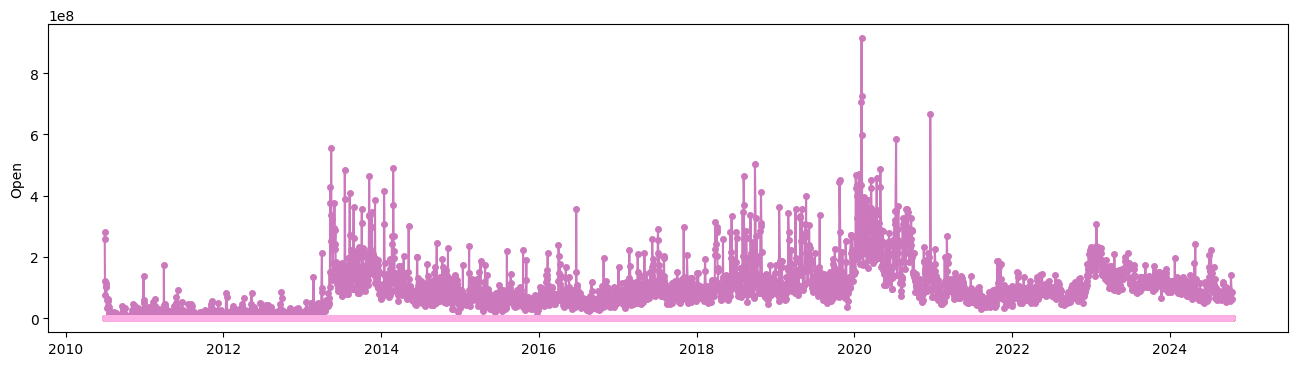

In [51]:
plot_series(TSLA_hist['Open'],TSLA_hist['High'],TSLA_hist['Low'],TSLA_hist['Close'],TSLA_hist['Volume'],TSLA_hist['Dividends'],TSLA_hist['Stock Splits']);

In [52]:
#FB_hist = FB_hist.sort_values(by='Date')
TSLA_hist.index = TSLA_hist.index.to_period('D')
TSLA_hist.index

/var/folders/l2/mh6902w91rxdry1pssd9vxlw0000gn/T/ipykernel_18417/1200935974.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  TSLA_hist.index = TSLA_hist.index.to_period('D')


PeriodIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
             '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
             '2010-07-12', '2010-07-13',
             ...
             '2024-10-02', '2024-10-03', '2024-10-04', '2024-10-07',
             '2024-10-08', '2024-10-09', '2024-10-10', '2024-10-11',
             '2024-10-14', '2024-10-15'],
            dtype='period[D]', length=3599)

In [53]:
TSLA_hist.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 3599 entries, 2010-06-29 to 2024-10-15
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3599 non-null   float64
 1   High          3599 non-null   float64
 2   Low           3599 non-null   float64
 3   Close         3599 non-null   float64
 4   Volume        3599 non-null   int64  
 5   Dividends     3599 non-null   float64
 6   Stock Splits  3599 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 224.9 KB


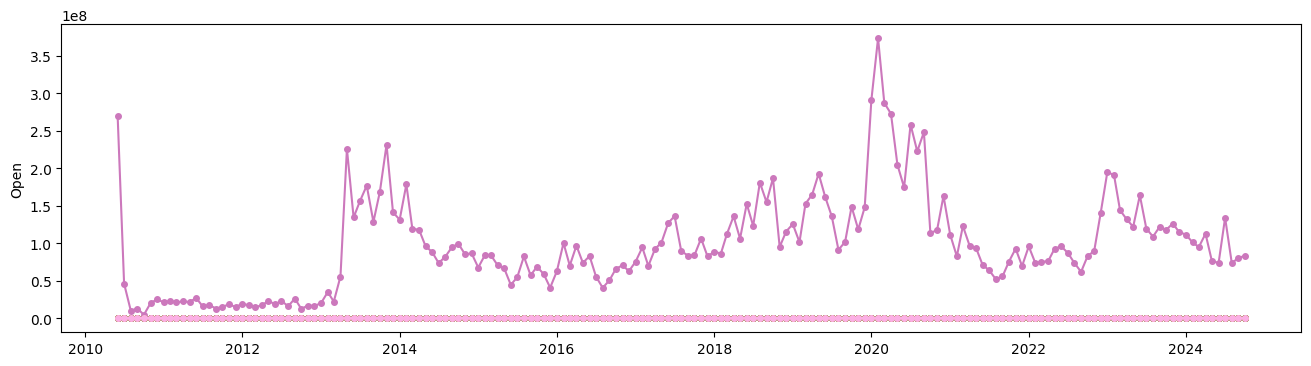

In [54]:
TSLA_hist = TSLA_hist.resample('M', convention='end').mean()
plot_series(TSLA_hist['Open'],TSLA_hist['High'],TSLA_hist['Low'],TSLA_hist['Close'],TSLA_hist['Volume'],TSLA_hist['Dividends'],TSLA_hist['Stock Splits']);

In [55]:
import yfinance as yf

TSLA = yf.Ticker("TSLA")


# show analysts recommendations
TSLA.recommendations



,period,strongBuy,buy,hold,sell,strongSell
0,0m,4,4,8,6,1
1,-1m,7,12,20,8,4
2,-2m,7,12,20,8,4
3,-3m,7,12,21,6,4


In [59]:
# get option chain for specific expiration
opt = TSLA.option_chain('2024-10-18')
# data available via: opt.calls, opt.puts
print(opt)

Options(calls=          contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0    TSLA241018C00025000 2024-10-15 13:34:30+00:00    25.0     197.55    0.0   
1    TSLA241018C00030000 2024-10-15 16:32:33+00:00    30.0     190.74    0.0   
2    TSLA241018C00035000 2024-09-30 17:55:01+00:00    35.0     224.95    0.0   
3    TSLA241018C00040000 2024-10-07 19:20:39+00:00    40.0     202.20    0.0   
4    TSLA241018C00045000 2024-05-09 18:07:54+00:00    45.0     128.50  133.3   
..                   ...                       ...     ...        ...    ...   
123  TSLA241018C00500000 2024-10-10 13:30:10+00:00   500.0       0.01    0.0   
124  TSLA241018C00510000 2024-10-07 15:43:07+00:00   510.0       0.01    0.0   
125  TSLA241018C00520000 2024-10-14 13:30:01+00:00   520.0       0.01    0.0   
126  TSLA241018C00530000 2024-10-14 17:18:42+00:00   530.0       0.01    0.0   
127  TSLA241018C00540000 2024-10-15 18:25:05+00:00   540.0       0.01    0.0   

        ask  change  perc